In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import splitfolders
import pathlib

2024-05-16 11:36:55.241087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 11:36:55.241223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 11:36:55.390362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

images = []
labels = []

for subfolder in os.listdir(df_path):
    
    subfolder_path = os.path.join(df_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  

    for image_filename in os.listdir(subfolder_path):

        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
df = pd.DataFrame({'image': images, 'label': labels})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   75000 non-null  object
 1   label   75000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


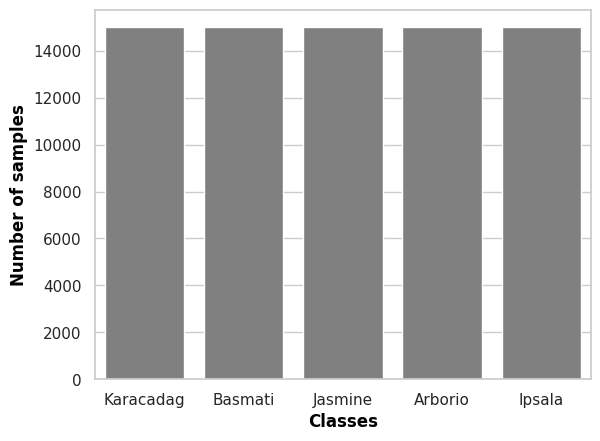

In [5]:
sns.set(style="whitegrid", palette="pastel")

ax = sns.countplot(x=df.label, color="gray")

ax.set_xlabel("Classes", fontdict={'weight': 'bold'})
ax.xaxis.label.set_color('black')

ax.set_ylabel("Number of samples", fontdict={'weight': 'bold'})
ax.yaxis.label.set_color('black')

plt.show()

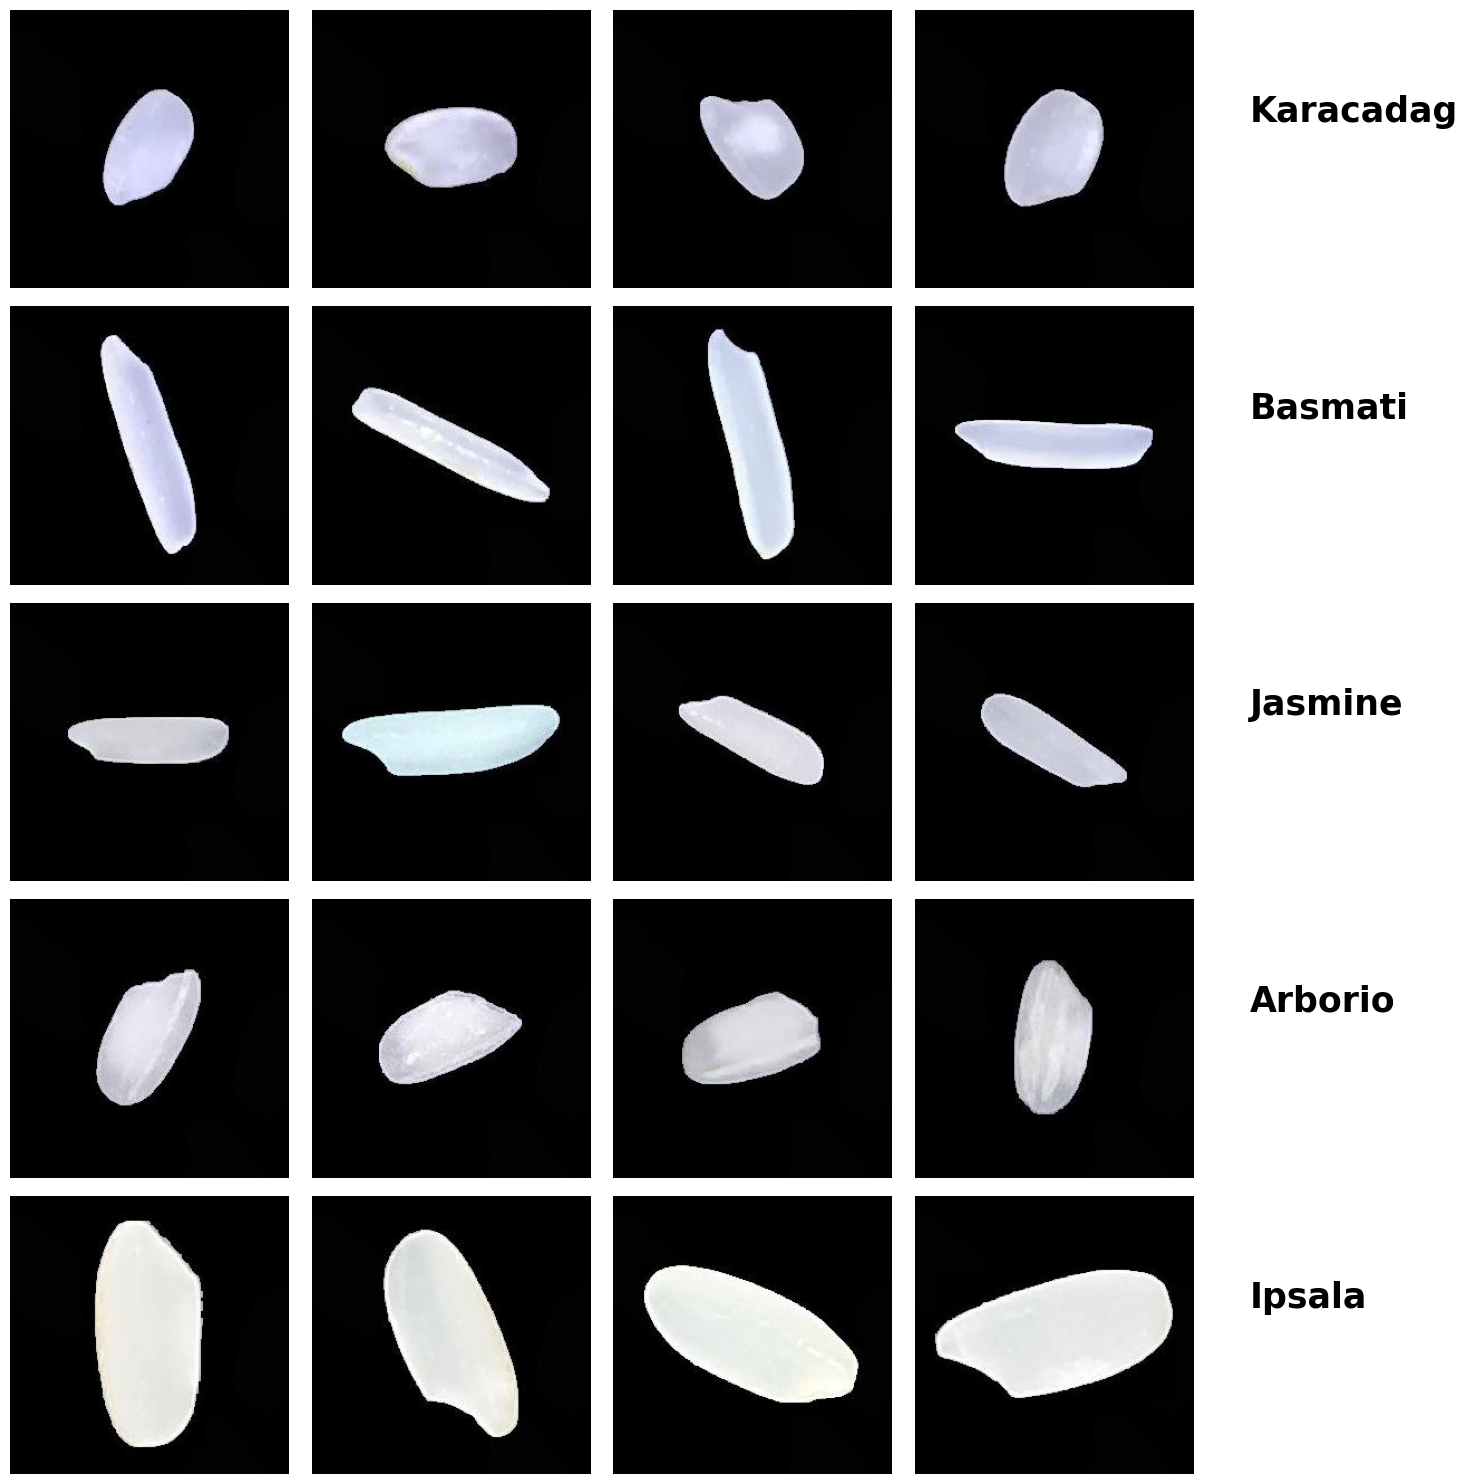

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))

categories = df['label'].unique()
num_categories = len(categories)

for i, category in enumerate(categories):
   
    filepaths = df[df['label'] == category]['image'].values[:4]

    for j, filepath in enumerate(filepaths):
        ax = axs[i, j]
        image = imread(filepath)
        ax.imshow(image)
        ax.axis('off')

    ax.text(300, 100, category, fontdict={'weight': 'bold'}, fontsize=25, color='black')

plt.tight_layout()
plt.show()

In [7]:
df_path = pathlib.Path(df_path)

In [8]:
splitfolders.ratio(df_path, output='df_splitted', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [07:08, 175.14 files/s]


In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

Train = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/df_splitted/train',
    labels='inferred',
    label_mode='categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)

Test = keras.utils.image_dataset_from_directory(
    directory= '/kaggle/working/df_splitted/test',
    labels='inferred',
    label_mode= 'categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)

Validation = keras.utils.image_dataset_from_directory(
    directory= '/kaggle/working/df_splitted/val',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    seed= 42
)


Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [10]:
train_batch = next(iter(Train))
validation_batch = next(iter(Validation))
test_batch = next(iter(Test))

image_batch, labels_batch = train_batch
print(f"Train Shape: {image_batch.shape} (Batches = {len(Train)})")
print(f"Train label: {labels_batch.shape}\n")

image_batch, labels_batch = validation_batch
print(f"Validation Shape: {image_batch.shape} (Batches = {len(Validation)})")
print(f"Validation label: {labels_batch.shape}\n")

image_batch, labels_batch = test_batch
print(f"Test Shape: {image_batch.shape} (Batches = {len(Test)})")
print(f"Test label: {labels_batch.shape}\n")

Train Shape: (32, 224, 224, 3) (Batches = 1641)
Train label: (32, 5)

Validation Shape: (32, 224, 224, 3) (Batches = 352)
Validation label: (32, 5)

Test Shape: (32, 224, 224, 3) (Batches = 352)
Test label: (32, 5)



In [11]:
INPUT_SHAPE = (224, 224, 3)

cnn = Sequential()

cnn.add(Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE))
cnn.add(MaxPooling2D(2, 2))
cnn.add(MaxPooling2D(2, 2))
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
cnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    49,562,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,828,229 (190.08 MB)

 Trainable params: 49,828,229 (190.08 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
CNN_model = cnn.fit(Train, validation_data= Validation, epochs=15)

Epoch 1/15


2024-05-16 11:44:30.685904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-05-16 11:44:30.685958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-05-16 11:44:30.685967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-05-16 11:44:30.685975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-05-16 11:44:30.685982: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-05-16 11:44:30.685990: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-05-16 11:44:30.685997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-05-16 11:44:30.686005: E 

   7/1641 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.2012 - loss: 1413.2135

I0000 00:00:1715859873.523030     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1639/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8963 - loss: 50.5731

2024-05-16 11:45:08.627098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.63812, expected 5.86815
2024-05-16 11:45:08.627148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.57545, expected 5.80549
2024-05-16 11:45:08.627157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.58905, expected 5.81908
2024-05-16 11:45:08.627165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.3889, expected 5.61894
2024-05-16 11:45:08.627172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23839, expected 5.46843
2024-05-16 11:45:08.627180: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.97291, expected 4.20294
2024-05-16 11:45:08.627188: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.35322, expected 4.58326
2024-05-16 11:45:08.627195: E external/local_xla/xla/

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8964 - loss: 50.5220

2024-05-16 11:45:16.420541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98575: 7.477, expected 6.6205
2024-05-16 11:45:16.420592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98577: 7.28497, expected 6.42847
2024-05-16 11:45:16.420601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98579: 6.06231, expected 5.20581
2024-05-16 11:45:16.420609: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98580: 7.30724, expected 6.45074
2024-05-16 11:45:16.420617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98581: 7.40547, expected 6.54897
2024-05-16 11:45:16.420624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98596: 6.73154, expected 5.87504
2024-05-16 11:45:16.420632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98629: 7.05243, expected 6.19593
2024-05-16 11:45:16.420640: E 

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.8964 - loss: 50.4966 - val_accuracy: 0.9671 - val_loss: 0.1648
Epoch 2/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9736 - loss: 0.1441 - val_accuracy: 0.9721 - val_loss: 0.1673
Epoch 3/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9769 - loss: 0.0999 - val_accuracy: 0.9780 - val_loss: 0.0810
Epoch 4/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9854 - loss: 0.0472 - val_accuracy: 0.9843 - val_loss: 0.0687
Epoch 5/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9909 - loss: 0.0269 - val_accuracy: 0.9783 - val_loss: 0.0956
Epoch 6/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.9819 - val_loss: 0.0850
Epoch 7/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9924 - loss: 0.0251 - val_accuracy: 0.9822 - val_loss: 0.0829
Epoch 8/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9941 - loss: 0.0

In [13]:
training_loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
training_acc = CNN_model.history['accuracy']
val_acc  = CNN_model.history['val_accuracy']

In [14]:
epoch_count = np.arange(1, len(training_loss) + 1)

/tmp/ipykernel_34/4161271124.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(epoch_count, training_loss, 'r--', color='gray', label='Training Loss')
/tmp/ipykernel_34/4161271124.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(epoch_count, val_loss, '--bo', color='purple', linewidth=2.5, label='Validation Loss')


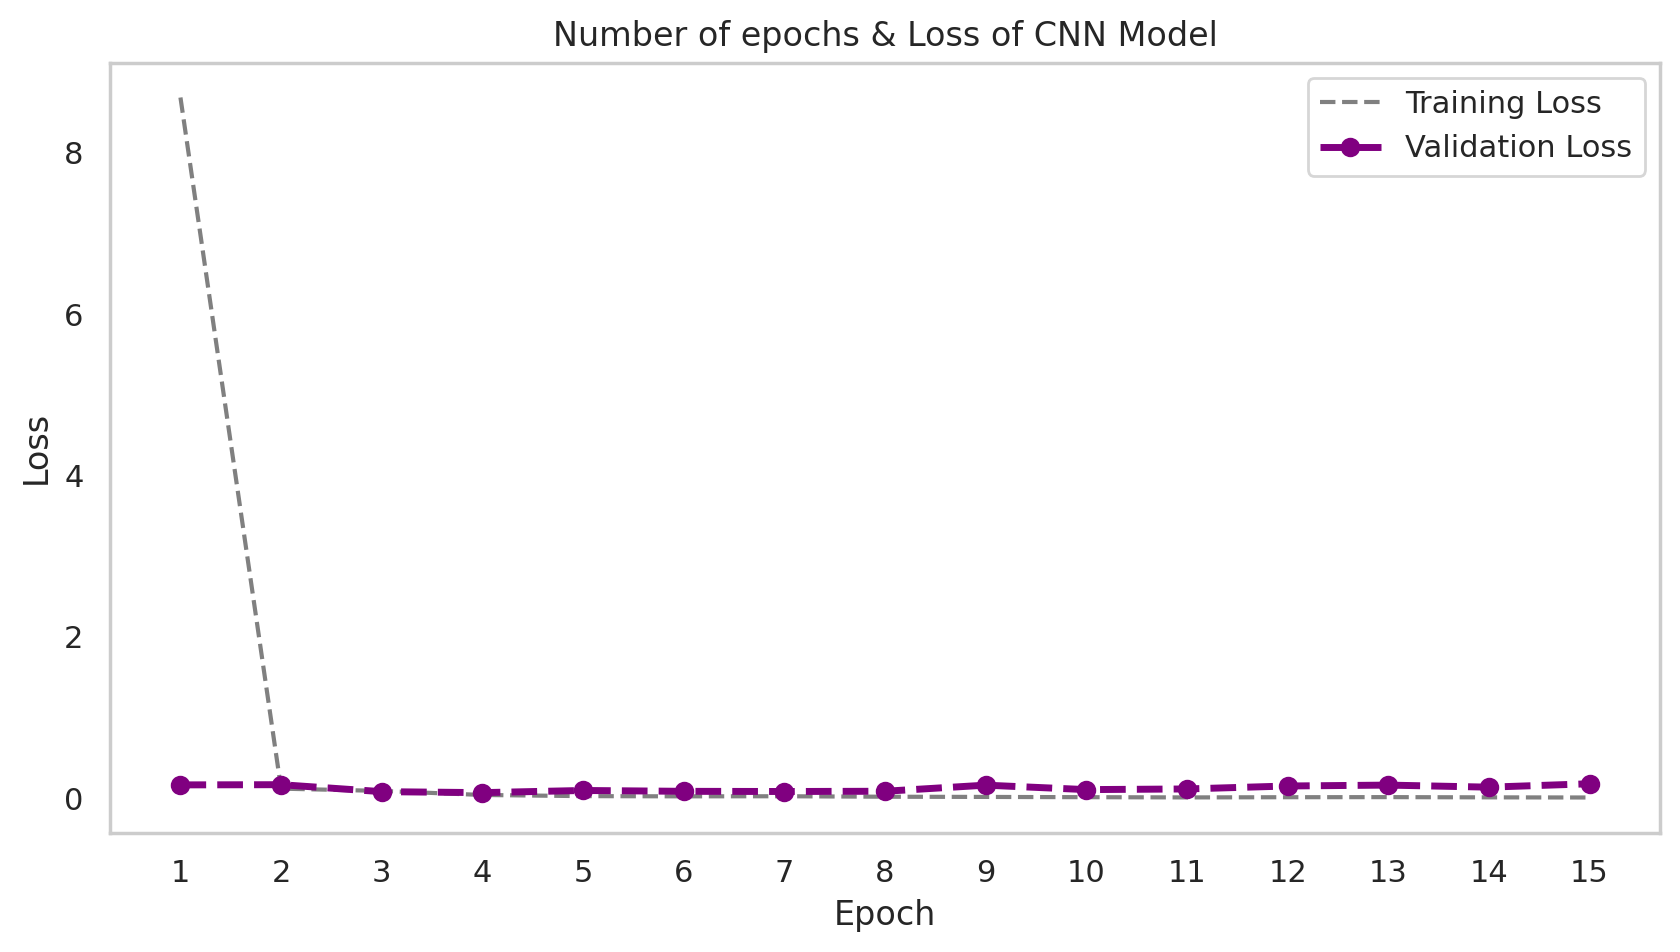

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

ax.plot(epoch_count, training_loss, 'r--', color='gray', label='Training Loss')
ax.plot(epoch_count, val_loss, '--bo', color='purple', linewidth=2.5, label='Validation Loss')

ax.legend()
ax.set_title('Number of epochs & Loss of CNN Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_xticks(np.arange(1, 16))
ax.grid(False)

plt.show()

/tmp/ipykernel_34/3601835855.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(epoch_count, training_acc, 'r--', color='gray', label='Training Accuracy')
/tmp/ipykernel_34/3601835855.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(epoch_count, val_acc, '--bo', color='purple', label='Validation Accuracy')


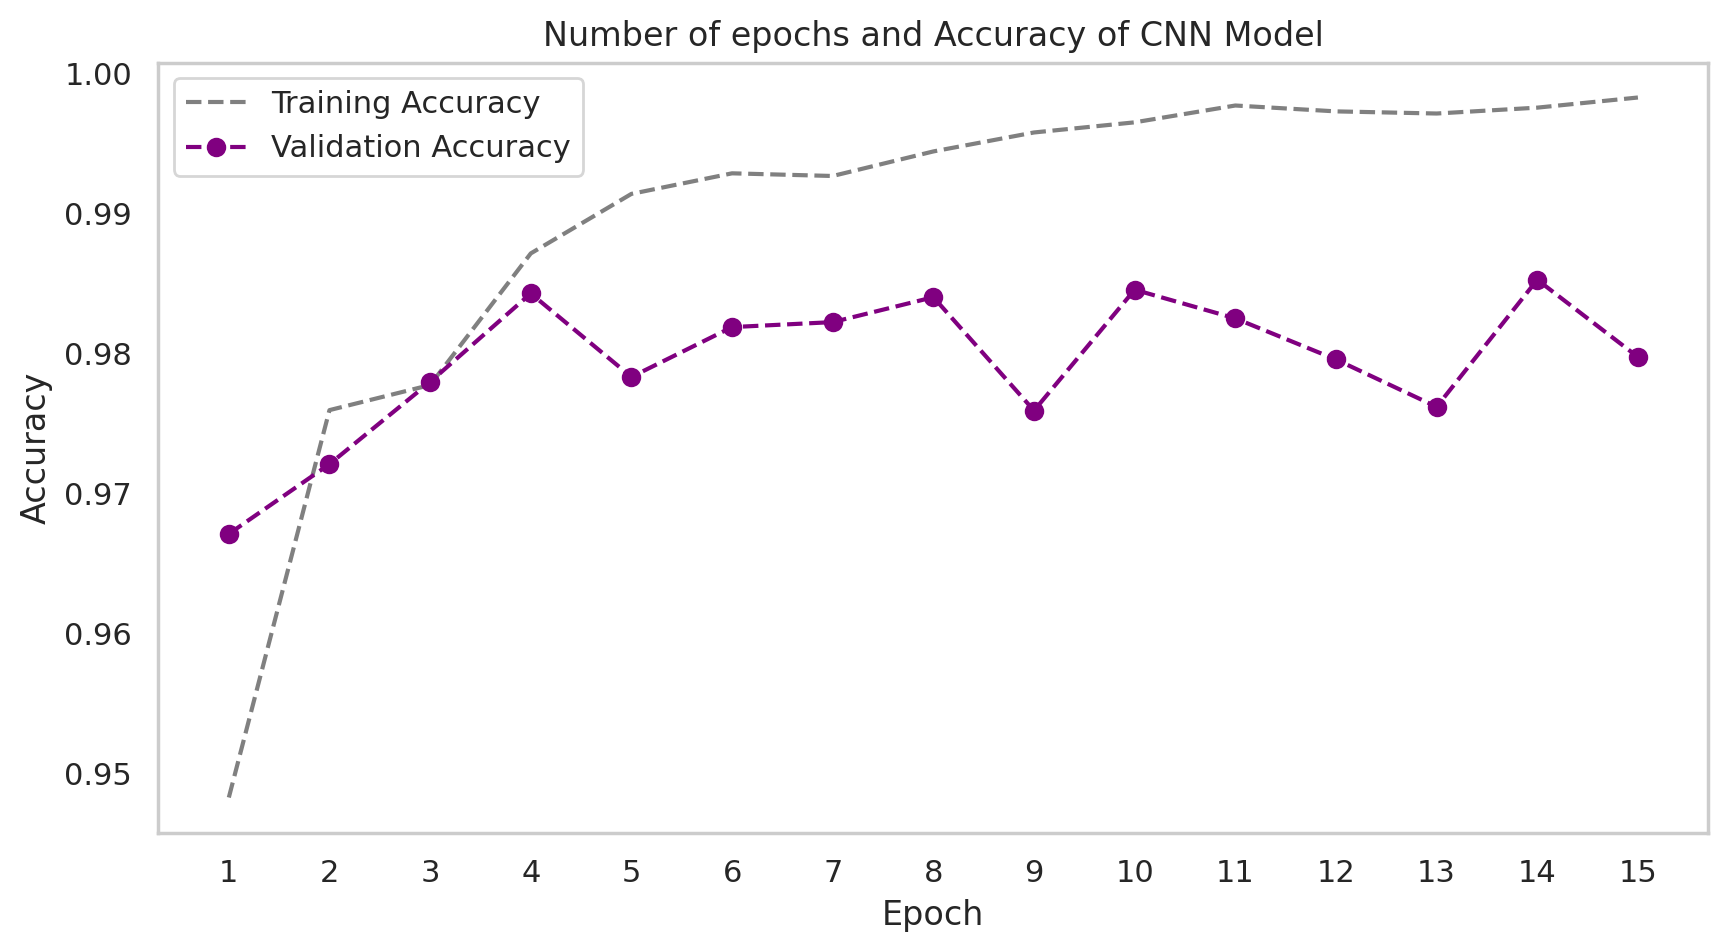

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

ax.plot(epoch_count, training_acc, 'r--', color='gray', label='Training Accuracy')
ax.plot(epoch_count, val_acc, '--bo', color='purple', label='Validation Accuracy')

ax.legend()
ax.set_title('Number of epochs and Accuracy of CNN Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_xticks(np.arange(1, 16))
ax.grid(False)

plt.show()

In [17]:
INPUT_SHAPE = (224, 224, 3)

cnn = Sequential()

cnn.add(Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE))
cnn.add(MaxPooling2D(2, 2))
cnn.add(MaxPooling2D(2, 2))
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    49,562,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,828,229 (190.08 MB)

 Trainable params: 49,828,229 (190.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
CNN_model = cnn.fit(Train, validation_data= Validation, epochs=4)

Epoch 1/4
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9044 - loss: 15.2584 - val_accuracy: 0.9623 - val_loss: 0.1427
Epoch 2/4
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9808 - loss: 0.0663 - val_accuracy: 0.9794 - val_loss: 0.0713
Epoch 3/4
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9876 - loss: 0.0400 - val_accuracy: 0.9847 - val_loss: 0.0571
Epoch 4/4
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9901 - loss: 0.0293 - val_accuracy: 0.9813 - val_loss: 0.0867


In [19]:
cnn.save("CNN_Model.h5")

In [20]:
Final_model = tf.keras.models.load_model('CNN_Model.h5')